DDPG Agent

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

In [3]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

# from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

C:\Users\30797\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
Actor(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], seed=10)

Actor(
  (fc1): Linear(in_features=34, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [16]:
Critic(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], seed=10)

Critic(
  (fcs1): Linear(in_features=34, out_features=256, bias=True)
  (fc2): Linear(in_features=258, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [5]:
from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToGymWrapper

In [7]:
game_path = 'C:/Users/30797/UnitySpace/RLCar/build/RLCar.exe'

In [6]:
unity_env = UnityEnvironment(game_path)
# unity_env = UnityEnvironment(base_port=5004)

env = UnityToGymWrapper(unity_env, 0)

NameError: name 'game_path' is not defined

In [7]:
revised_ob_space = 16

In [79]:
agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], random_seed=10)
# agent = Agent(state_size=revised_ob_space, action_size=env.action_space.shape[0], random_seed=10)

In [9]:
state = env.reset()
state

array([1.        , 1.        , 0.        , 0.6383529 , 0.        ,
       0.50771314, 0.        , 0.34760505, 0.        , 0.2764671 ,
       0.        , 0.26906538, 0.        , 0.21400076, 0.7071068 ,
       0.7071068 , 0.9999567 , 0.        ], dtype=float32)

In [54]:
# idx = [1,3,5,7,9,11,13,14,15,16,17,18]
# state2 = state[idx]
# len(state2)

12

In [8]:
def save_states():
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    
# def filter_state(state):
#     idx = [1,3,5,7,9,11,13,14]
#     state2 = state[idx]
#     return state2

def filter_state(state):
    return state

In [11]:
# filter_state(state)
action = agent.act(state)
action

C:\Users\30797\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


array([0.08022818, 0.09354205], dtype=float32)

In [80]:
scores, avg_scores = [],[]
def ddpg(n_episodes=2000, max_t=11000):
    scores_deque = deque(maxlen=200)
    scores = []
    max_score = -np.Inf
    for i_episode in tqdm(range(1, n_episodes+1)):
        state = env.reset()
        state = filter_state(state)
        agent.reset()
        score = 0
        for t in range(max_t):
#             print(len(state))
            if(state[-1] == 0):
                action = np.array([0,0])
            else:
                action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = filter_state(next_state)
#             print(len(next_state))
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 5 == 0:
            torch.save(agent.actor_local.state_dict(), f'checkpoint_actor_3_E{i_episode}_S{score}.pth')
            torch.save(agent.critic_local.state_dict(), f'checkpoint_critic_3_E{i_episode}_S{score}.pth')
            scores.append(score)
            avg_scores.append(np.mean(scores_deque))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 5	Average Score: -156.00	Score: -470.00
Episode 10	Average Score: -183.00	Score: 100.00
Episode 15	Average Score: -32.00	Score: 1110.00
Episode 20	Average Score: 130.50	Score: 190.000
Episode 25	Average Score: 122.80	Score: 220.000
Episode 30	Average Score: 282.67	Score: 1180.00
Episode 35	Average Score: 383.14	Score: 270.000
Episode 40	Average Score: 344.00	Score: 50.000
Episode 45	Average Score: 297.33	Score: -200.00
Episode 50	Average Score: 266.40	Score: 100.000
Episode 55	Average Score: 251.27	Score: 100.00
Episode 60	Average Score: 227.67	Score: -460.00
Episode 65	Average Score: 214.62	Score: 40.000
Episode 70	Average Score: 202.43	Score: 50.00
Episode 75	Average Score: 186.40	Score: -230.00
Episode 80	Average Score: 166.12	Score: -10.000
Episode 85	Average Score: 148.94	Score: -350.00
Episode 90	Average Score: 116.78	Score: -650.00
Episode 95	Average Score: 98.63	Score: -370.000
Episode 98	Average Score: 84.18	Score: -370.00

KeyboardInterrupt: 

In [102]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.

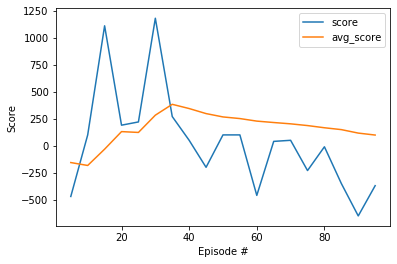

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1) * 5, scores, label='score')
plt.plot(np.arange(1, len(avg_scores)+1) * 5, avg_scores, label='avg_score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [26]:
# test run

def ddpg_eval():
    agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], random_seed=10)
#     agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], random_seed=30)

    agent.actor_local.load_state_dict(torch.load('checkpoint_actor_3_E30_S1180.0.pth'))
    agent.critic_local.load_state_dict(torch.load('checkpoint_critic_3_E30_S1180.0.pth'))
    
#     agent.actor_local.load_state_dict(torch.load('checkpoint_actor_3_E15_S1110.0.pth'))
#     agent.critic_local.load_state_dict(torch.load('checkpoint_critic_3_E15_S1110.0.pth'))


    state = env.reset()
    state = filter_state(state)
    agent.reset()
    score = 0
    max_t = 10000
    for t in range(max_t):
        if(state[-1] == 0):
            action = np.array([0,0])
        else:
            action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = filter_state(next_state)
        state = next_state
        score += reward
        if done:
            break 
    print("score=", score)
    
env = UnityToGymWrapper(UnityEnvironment(base_port=5004), 0)
# env = UnityToGymWrapper(UnityEnvironment(game_path), 0)
ddpg_eval()


2020-12-08 20:09:06 INFO [environment.py:205] Listening on port 5004. Start training by pressing the Play button in the Unity Editor.
2020-12-08 20:09:16 WARNING [environment.py:104] WARNING: The communication API versions between Unity and python differ at the minor version level. Python API: 1.2.0, Unity API: 1.0.
This means that some features may not work unless you upgrade the package with the lower version.Please find the versions that work best together from our release page.
https://github.com/Unity-Technologies/ml-agents/releases
2020-12-08 20:09:16 INFO [environment.py:271] Connected new brain:
My Behavior?team=0
2020-12-08 20:09:16 WARNING [__init__.py:92] The environment contains multiple observations. You must define allow_multiple_obs=True to receive them all. Otherwise, only the first visual observation (or vector observation ifthere are no visual observations) will be provided in the observation.


score= 1360.0


In [27]:
env.close()